#parser:

In [8]:
import collections 
import inspect
import copy  
from collections import defaultdict

In [9]:
%run tokenizer.ipynb
%run util.ipynb

%xmode Plain
%pdb on

temp+for+internalUse2
('temp+for+internalUse3', 'temp+for+internalUse3')
Exception reporting mode: Plain
Automatic pdb calling has been turned ON


In [16]:
class parser(SSA,Reg,parser_util,BB,SSA_code,Random_variable_gen):
    def __init__(self,tokens,rules):
        self.tokens=collections.deque([i for i in tokens if i.type!='COMMENT'])
        SSA.__init__(self)
        #Reg.__init__(self)
        parser_util.__init__(self)
        BB.__init__(self)   
        self.Random_variable=Random_variable_gen()
        self.loop_head=[]
        self.if_head=[]    
    
    def _update_live(self,G_reverse1):
        for i in self.loop_head:#parent[0] is inside the loop
            While_child=nx.descendants(G_reverse1,i[1])
            While_child.update([i[1]])
            for j in While_child:
                self.node[j]["live_in"].update(self.node[i[0]]["live_out_right"])
                
    def make_inference_graph(self):
        #https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.cycles.find_cycle.html
        import matplotlib.pyplot as plt
        self.graph_inf=nx.Graph()
        
        #build graph
        G_reverse=self.G.reverse(copy=True)        
        G_reverse=self._remove_loops(G_reverse)
        
        # fisrt pass of processing
        self._processing_inference_graph(copy.deepcopy(G_reverse))
        G_vis=self.visulize_live("1",G=None)        
        
        # propagate live to children(for While)
        self._update_live(G_reverse.reverse(copy=True))
        G_vis=self.visulize_live("2",G=G_vis)
        
        # second pass of processing, and generating the interference graph. 
        self._processing_inference_graph(copy.deepcopy(G_reverse),second_pass=True)
        G_vis=self.visulize_live("3",G=G_vis)      
        
    def color_inf_graph(self):        
        nx.draw(self.graph_inf,with_labels=True,pos=nx.spring_layout(self.graph_inf))  
        a=nx.greedy_color(self.graph_inf)
        print(max([v for k,v in a.items()]),a)   
 
        
    def _init_live_left_right(self,node):
        if_bb,loop_bb=False,False
        live_left,live_right=set(),set()
        live=set(self.node[node]["live_in"])
        
        if node in [i[0] for i in self.if_head]:                    
            if_bb,live_left,live_right=True,set(live),set(live);print("if_BB detected!",node)   
        if node in [i[0] for i in self.loop_head]:                    
            loop_bb,live_left,live_right=True,set(live),set(live);print("loop_BB detected!",node)  
        return if_bb,loop_bb,live,live_left,live_right
    
    def _propagte_live_others(self,G_reverse,node,live,live_left,live_right,if_bb,loop_bb):
        #### update live? 
        #TODO: how can I remove 'live'?
        self.node[node]["live_out"]=set(live)
        #### propagate live to the mother and others bb
        if if_bb==True:
            f=[i for i in self.if_head if i[0]==node][0]
            self.node[node]["live_out_left"]=set(live_left)
            self.node[node]["live_out_right"]=set(live_right)
            #self.if_head= [(merge_bb,newbbif,mother_bb) | (merge_bb,newbbif,newbbelse)]
            self.node[f[1]]["live_in"].update(live_left)
            self.node[f[2]]["live_in"].update(live_right)

        elif loop_bb==True:
            f=[i for i in self.loop_head if i[0]==node][0]
            self.node[node]["live_out_left"]=set(live_left)
            # self.node[node]["live_out_right"] will be used in propagating the live to While childs later
            self.node[node]["live_out_right"]=set(live_right)
            #self.loop_head= [(join_node,inside_while_bb,join_mother)]
            self.node[f[2]]["live_in"].update(live_left)
            #self.node[f[2]]["live_in"].update(live_right)
        else:
            for i in G_reverse.successors(node):
                self.node[i]["live_in"].update(self.node[node]["live_out"])
                
    def _add_SSA_number_all(self,if_bb,loop_bb,if_phi,loop_phi,inst,live,live_left,live_right):            
        if if_phi: self._split_live(live_left,live_right,inst)
        elif loop_phi: self._split_live(live_left,live_right,inst)
        else:self._add_to_both(live,live,inst)

        if if_bb and not if_phi: self._add_to_both(live_left,live_right,inst)
        if loop_bb and not loop_phi: self._add_to_both(live_left,live_right,inst)  
        
        #there is no Phi is this type of BB
        #if not if_bb and not loop_bb: self._add_to_both(live,live,inst)

    def _generate_interference_graph(self,live,inst):
        for to_node in live:
            self.graph_inf.add_edges_from([(to_node,inst.SSA_number)])

    def _process_live_single_bb(self,node,if_bb,loop_bb,live,live_left,live_right,second_pass):
        for inst in reversed(self.node[node]["code"]):
            if_phi,loop_phi= if_bb and inst.op=="Phi",loop_bb and inst.op=="Phi"

            ###what to do in the case of CSE optimization?
            if "CSE" in inst.op or "BRA" in inst.op: continue # 'any' python builtin?
            if node!=self.number and inst.SSA_number not in live: continue #dead code elimination

            #if if_bb:print("hoooooy",sorted(live),sorted(live_left),sorted(live_right),inst)
            ########## generate interference Graph: has to do after the post processing: add edge to graph
            if second_pass: self._generate_interference_graph(live,inst)

            ########## remove current inst from the all live sets
            self._remove_SSA_number_all(inst.SSA_number,live,live_left,live_right)

            ########## add operand of inst to the live set
            self._add_SSA_number_all(if_bb,loop_bb,if_phi,loop_phi,inst,live,live_left,live_right)            

        return live,live_left,live_right
    
    def _processing_inference_graph(self,G_reverse,second_pass=False):
        #G_reverse does not have a loops!        
        while len(G_reverse)>0:
            zero_entry=[node for node in G_reverse if G_reverse.in_degree(node)==0]
            
            while len(zero_entry)>0:
                node=zero_entry.pop()
                #print(node,"is pre processing!")
                
                # init the live sets, and detect if it is loop or if joint bb
                if_bb,loop_bb,live,live_left,live_right=self._init_live_left_right(node)
                
                ### process the live of a BB (node), and generate Intereference Graph if it is second pass
                live,live_left,live_right=self._process_live_single_bb(node,\
                                            if_bb,loop_bb,live,live_left,live_right,second_pass)                
                
                #### propagate live to node, the mother, and others bb
                self._propagte_live_others(G_reverse,node,live,live_left,live_right,if_bb,loop_bb)
                    
                G_reverse.remove_node(node)                    

0 1 2 3 0 1 2 3 4 0 1 0 0 2 3 2 2 3 3 4 inserting phi...
inserting phi...
[(3, 4, 'forward'), (4, 3, 'forward')]
no loop found!
(9) ADD (12), #2
(10) ADD (13), #3
(3, 'blt', '(14)')
0 0 2 3 2 2 3 3 inserting phi...
inserting phi...
[(3, 4, 'forward'), (4, 3, 'forward')]
[(7, 8, 'forward'), (8, 7, 'forward')]
no loop found!
(18) ADD (20), #5
(19) ADD (21), #6
(7, 'blt', '(22)')
inserting phi...
inserting phi...
inserting phi...
(1, 'blt', '(22)')
0 0 1 3 ('dom_tree from entry node,', 1, [(1, 1), (2, 1), (3, 2), (4, 3), (5, 3), (6, 1), (7, 6), (8, 7), (9, 7), (10, 1)])
('Dom treee_reachable from node:', 1, set([2, 3, 4, 5, 6, 7, 8, 9, 10]))
(1, 7, (28) blt (22), None, (23) blt (22), None, 'are the same: CSE')
[(3, 4, 'forward'), (4, 3, 'forward')]
[(7, 8, 'forward'), (8, 7, 'forward')]
no loop found!
('if_BB detected!', 10)
('loop_BB detected!', 7)
('loop_BB detected!', 3)
('if_BB detected!', 10)
('loop_BB detected!', 7)
('loop_BB detected!', 3)
(4, {1: 2, 2: 0, 3: 3, 4: 4, 5: 1, 7: 2, 9

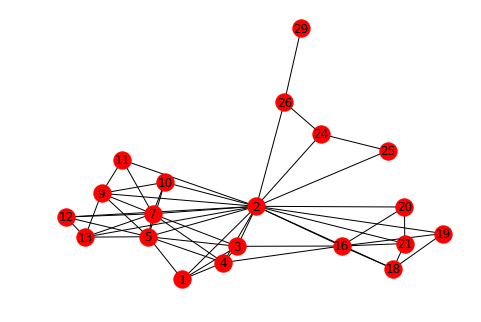

In [17]:
code='''
main
var a, b, c, d;
{
	let a <- 1;
	let b <- 2;
	let c <- 3;
	let d <- 4;
    let k <- 5;
    
	if a< b then
		let a <- a + 1;
		while c < d do
			let c <- c + 2;
			let d <- d + 3 + k
		od
	else
		let a <- a + 4;
		while c < d do
			let c <- c + 5;
			let d <- d + 6
		od
	fi;
    
	let a <- a + b + d
}.'''
%matplotlib inline    
def testa(code):
    tk=Tokenizer(l_kewords,token_specification)
    tk.tokenize_program(code)
    #tk.print_tokens()
    c=parser(tk.result,rules) 
    c.check_computation()    
    c.visulize()

    # these lines are for CSE: need to be refactorized!
    c.build_graph()
    c.all_dom_pair()
    c.visulize()
    !graph-easy grid.dot --as_dot | dot -Tpng -o graph_before_cse.png
    
    
    #reg allocation:
    c.make_inference_graph()
    c.color_inf_graph()
    
    !graph-easy grid.dot --as_dot | dot -Tpng -o graph.png
    !graph-easy grid_live.dot --as_dot | dot -Tpng -o graph_live.png
    
testa(code)

from IPython.display import Image
#Image(filename='graph.png') 



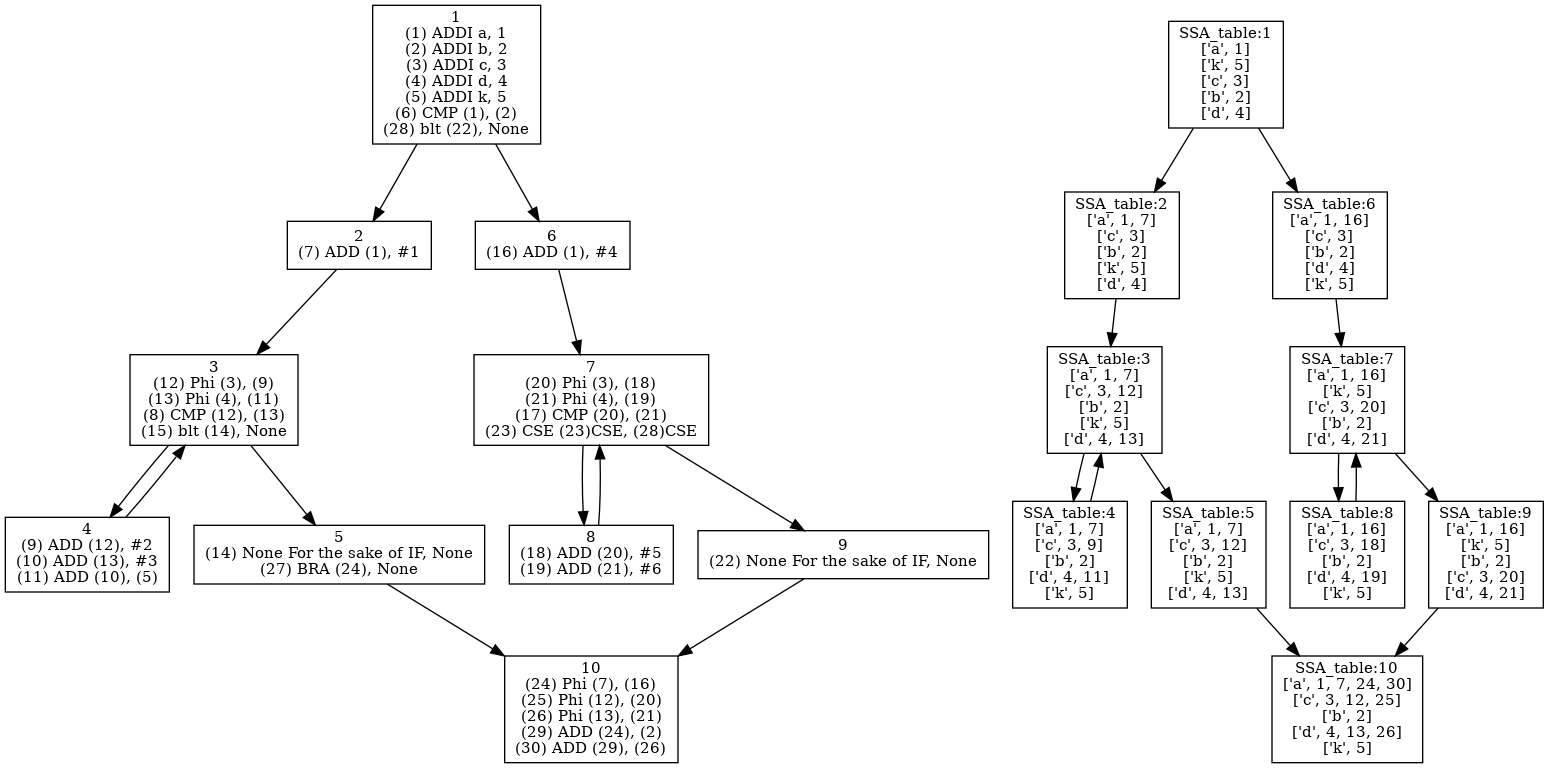

In [5]:
Image(filename='graph_before_cse.png') 
Image(filename='graph.png')

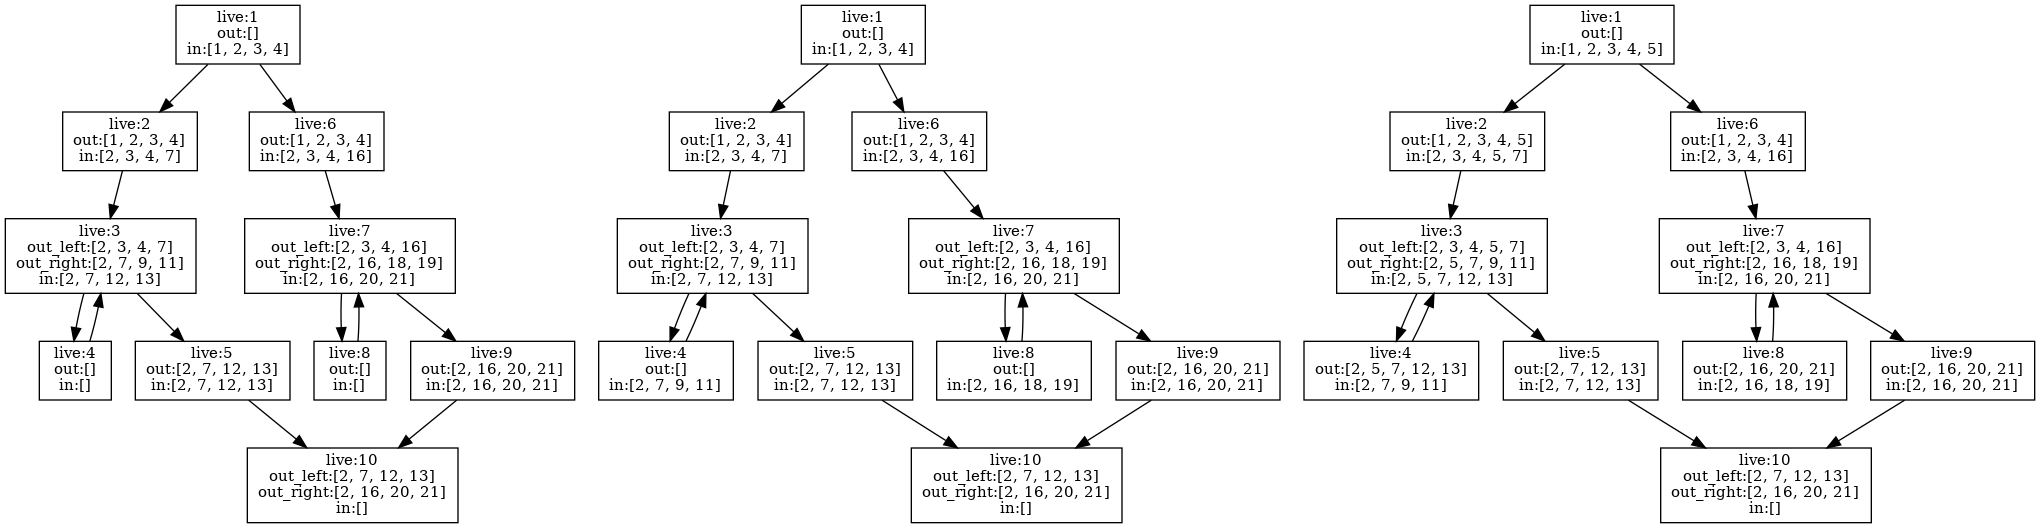

In [6]:
Image(filename='graph_live.png')

In [7]:
# to do: 
#ok: deal with a<- a+b+c+d+a * b*c*d
#deal with a<- 1:
    #Addi for now!
#ok: complete the while SSA generator
    # need to refactorize the code!
    # need to check: if it works for nested while and if: not now! the bb number is wrong for now(return path)!
    # check for nested if/while almost correct! need to check more
#remove redundant computations: a<-x+y  b<-x+y
#make 'live' graph of the SSA variables
#deal with arrays
#deal with functions/procedures: 
    #function BB: ok, 
    #call
    #return value
#deal with reserved functions: write, read,...
#deal with uninitilized variables
#maybe the list of SSA_table is wrong when I merge them in joint/merge bbs. 
    #it depends on how I use it for the later step(make 'live' graph of the SSA variables)